In [1]:
import csv
import numpy as np 
import random
import time
# sve_ivp
import os
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})
from os.path import dirname, realpath, sep, pardir
import sys
sys.path.append('/blue/pdixit/hodaakl/A5MCMC_IGF_FoxO/Code/')


from UPDATE_LM_FNS import calculate_constraints, update_lambda, openfile
from PredictionFunction_v2 import cell_pred_fn_new



In [2]:
on_mac = False 
on_thinkpad = False 
on_hpg = True

In [3]:
if on_mac == True: 
    data_path = "/Volumes/hodaakl/"
if on_thinkpad== True: 
    data_path = "//exasmb.rc.ufl.edu/blue/pdixit/hodaakl/"
if on_hpg == True: 
    data_path = "/blue/pdixit/hodaakl/"

# specify the project you are working on     
spec_folder = data_path + 'A5MCMC_IGF_FoxO/'

In [4]:

def read_csv( path , index = 0, dat = 'cellpreds' ): 
    if dat == 'cellpreds':
        fn = path + f'cellpreds_{index}.csv'
    if dat == 'moments':
        fn = path + f'moments_{index}.csv'
    if dat == 'lambdas':
        fn = path + f'Lambdas.csv'
    if dat == 'params': 
        fn = path + f'params_{index}.csv'  
    if dat == 'variance': 
        
        fn = path + f'variance_{index}.csv'
    
    df = pd.read_csv(fn, sep = ',', header = None) 
    
    table = df.to_numpy()
    return table
    

### Start here

In [8]:
on_hpg=True
if on_mac == True: 
    data_path = "/Volumes/hodaakl/"
if on_thinkpad== True: 
    data_path = "//exasmb.rc.ufl.edu/blue/pdixit/hodaakl/"
if on_hpg == True: 
    data_path = "/blue/pdixit/hodaakl/"

# specify the project you are working on     
spec_folder = data_path + 'A5MCMC_IGF_FoxO/'
folder_out ='0413_Constrained/' #    Lambda = old_lambda.copy() + alpha_arr*(Error)/true_constraints

path = spec_folder + folder_out



In [9]:
path = spec_folder + folder_out
err_fn = path +  'Errors.csv'

acc_fn = path + 'Info.csv'
lambda_fn = path + 'Lambdas.csv'
# read_dictionary = np.load(spec_folder+'Arrays_for_max_ent/cons_dict_mu_lnx_fraclr_020322.npy',allow_pickle='TRUE').item()
# real_cons = read_dictionary['array']
# ncons = len(real_cons)
# cons_title = read_dictionary['labels']
df = pd.read_csv(err_fn, sep = ',', header = None , ) 
err_np = df.to_numpy()
df_l = pd.read_csv(lambda_fn, sep = ',', header = None)
lambda_np = df_l.to_numpy()
latest_iteration = lambda_np.shape[0] -1



In [10]:
latest_iteration

162

In [11]:
# load the file 
concfile = path +  f'cellpreds_{latest_iteration}.csv'
df = pd.read_csv(concfile, sep = ',', header = None)
# concdat = df.to_numpy()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539897 entries, 0 to 539896
Columns: 322 entries, 0 to 321
dtypes: float64(322)
memory usage: 1.3 GB


In [13]:
df = df.to_numpy()

In [14]:
df.shape

(539897, 322)

In [32]:
# NumPars = 7 # number of parameters in this system
# par_data = data[:,-NumPars:]
# par_filename = path + f'/params_{iteration}.csv' 
# # dump the numpy matrix into a csv file 
# np.savetxt(par_filename, par_data, delimiter=",")
# outarr = np.concatenate((pred_curr, mu_curr, v_curr , k  ))

In [17]:
parslen = 14
condn = 42 
mat = df[:,-parslen:]
print(mat.shape)
## save parameters 
fn = path + f'params_{latest_iteration}.csv'
np.savetxt(fn, mat, delimiter=",")

(6518, 14)


In [16]:
mat = df[:,:condn*9]
print(mat.shape)
## save parameters 
fn = path + f'PercentilePreds_{latest_iteration}.csv'
np.savetxt(fn, mat, delimiter=",")

(539897, 252)


In [17]:
mat = df[:,condn*9:condn+condn*9]
print(mat.shape)
## save parameters 
fn = path + f'mu_{latest_iteration}.csv'
np.savetxt(fn, mat, delimiter=",")

(539897, 28)


In [18]:
mat = df[:,condn*10:condn+condn*10]
print(mat.shape)
## save parameters 
fn = path + f'var_{latest_iteration}.csv'
np.savetxt(fn, mat, delimiter=",")

(539897, 28)


In [17]:
## load mu 
# latest_iteration = 141
mu_fn = path + f'mu_{latest_iteration}.csv'
var_fn = path + f'var_{latest_iteration}.csv'
df = pd.read_csv(mu_fn, sep = ',', header = None) 
mu_mat = df.to_numpy()
df = pd.read_csv(var_fn, sep = ',', header = None) 
var_mat = df.to_numpy()

mu_mat.shape
var_mat.shape

(539897, 28)

# distribution analysis 


In [ ]:
# 

In [8]:
var_mat.shape[0]/150


133.30666666666667

In [19]:
# load the means and the second moments of the data from the constraint dictionary saved befr

MuS_consDict = np.load(spec_folder + 'Arrays_for_max_ent/Cons_1213_MuS.npy', allow_pickle=True).item()


In [25]:
mu_arr_og = MuS_consDict['array'][:28]
s_arr_og = MuS_consDict['array'][-28:]
# print(mu_arr_og.shape)
# print(s_arr_og.shape)
var_arr_og = s_arr_og - mu_arr_og**2
alpha_arr_og = (mu_arr_og**2)/(var_arr_og)
scale_arr_og = var_arr_og/mu_arr_og

In [26]:
### now for the simulated cells
mu_model = np.mean(mu_mat, axis = 0)
var_model = np.var(mu_mat, axis = 0)
a_arr_model = (mu_model**2)/(var_model)
scale_arr_model = var_model/mu_model

print(a_arr_model.shape)

(28,)


In [28]:
import scipy.stats as stats 

In [47]:
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM

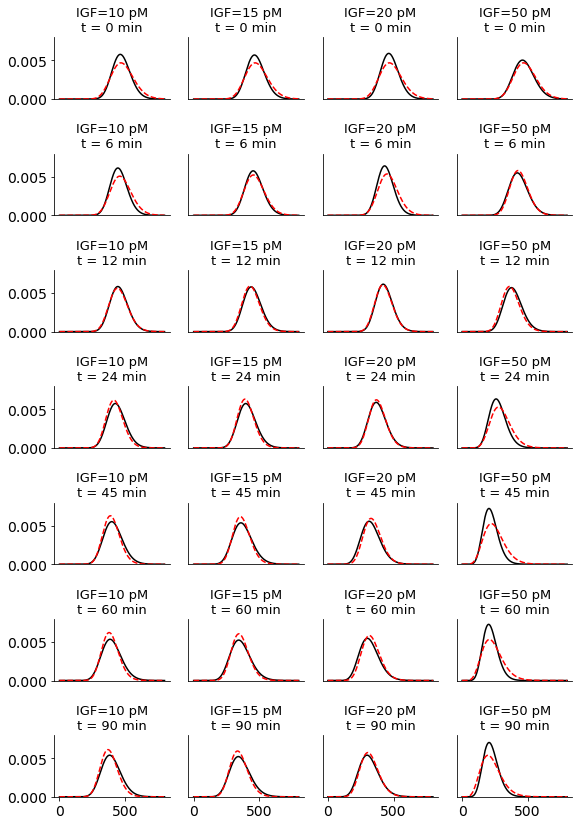

In [59]:
w , l = 8.27, 11.69
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=7, ncols=4,figsize = (w, l))
nconds = 28
r = 0; c = 0
for i in range(nconds):
    # mu_og = mu_arr[i] ; var_og = 
    x = np.linspace (0, 800, 1000) 

# #calculate pdf of Gamma distribution for each x-value
    y_og = stats.gamma.pdf(x, a=alpha_arr_og[i], scale=scale_arr_og[i])
    # y_og_min = stats.gamma.pdf(x, a=a_og_min, scale=s_og_min)

    y_model = stats.gamma.pdf(x, a=a_arr_model[i], scale=scale_arr_model[i])

    # #create plot of Gamma distribution
    ax[r,c].plot(x, y_og, c = 'k',  label = 'Data ')

    ax[r,c].plot(x, y_model, '--', c = 'r', label = 'Model')
    ax[r,c].set_ylim([0,0.008])
#     ax[r,c].set_title(f'EGF = {np.round(Larr[i],3)} nM', fontsize = 15)
    # ax[r,c].set_yticks([])
    # #display plot
#     if c == 0 and r ==0:
#         ax[r,c].legend(frameon = False, loc = 'best')
    ax[r,c].spines['top'].set_visible(False)
    ax[r,c].spines['right'].set_visible(False)
    ax[r,c].set_title(f'IGF={int(L[c]*1000)} pM\nt = {int(times_arr[r]/60)} min', fontsize = 13)
    if r != 6:
        ax[r,c].set_xticks([])
    if c !=0: 
        ax[r,c].set_yticks([])
        
    # ax[r,c].spines['left'].set_visible(False)
    # a
    r +=1 
    if r==7:
        
        r = 0
        c+=1 

    # ax[r,c].xlabel('EGFR number', fontsize = 15)
    # ax[r,c].ylabel('PDF', fontsize = 15)
    # plt.show()
plt.tight_layout()
fig_directory = '/blue/pdixit/hodaakl/A5MCMC_IGF_FoxO/'
# # ax.spines['top'].set_visible(False)
# # ax.spines['right'].set_visible(False)
# # ax.set_ylim([0,.4])
fname = f'{fig_directory}fig_IGF_distributions.pdf'
plt.savefig(fname,      dpi=300,bbox_inches = 'tight')

    

In [18]:
## compare the results 
ax = 0
s_mat = mu_mat**2 - var_mat
Mu_Pop = np.mean(mu_mat, axis = ax)
Mu_max = np.max(mu_mat, axis = ax)


print(Mu_Pop.shape)
S_Pop = np.mean(s_mat, axis = ax)

(28,)


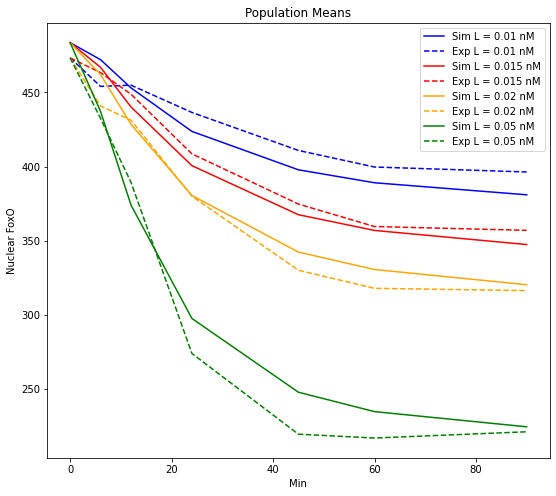

In [22]:
fig, axis = plt.subplots(figsize = (9,8))
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)
c = ['b','r','orange','g','k','purple']
# means_sim_conc = np.array([])
i=0
for li in range(nL):
    plt.plot(times_arr/60, Mu_Pop[i:i+nT], label = f'Sim L = {L[li]} nM', c=c[li])
    plt.plot(times_arr/60, MuS_consDict['array'][i:i+nT], '--', label = f'Exp L = {L[li]} nM', c=c[li])
    
    
    i+=nT

plt.title('Population Means')
plt.xlabel('Min')
plt.ylabel('Nuclear FoxO')
plt.legend()

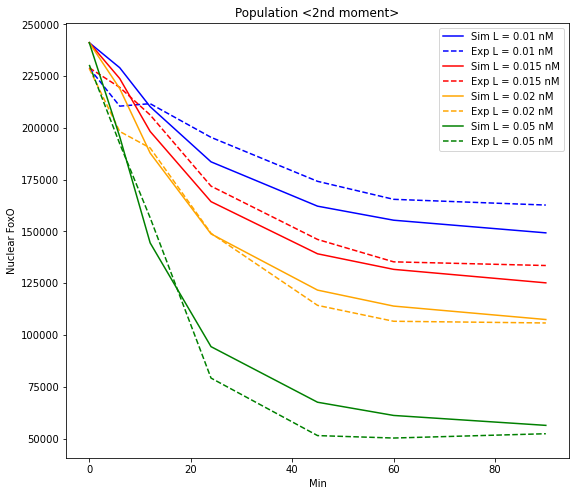

In [23]:
fig, axis = plt.subplots(figsize = (9,8))
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)
f = nConds
c = ['b','r','orange','g','k','purple']
i=0
for li in range(nL):
    plt.plot(times_arr/60, S_Pop[i:i+nT], label = f'Sim L = {L[li]} nM', c=c[li])
    plt.plot(times_arr/60, MuS_consDict['array'][f+i:f+i+nT], '--', label = f'Exp L = {L[li]} nM', c=c[li])
    
    i+=nT

plt.title('Population <2nd moment>')
plt.xlabel('Min')
plt.ylabel('Nuclear FoxO')
plt.legend()

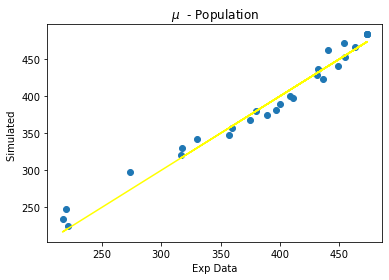

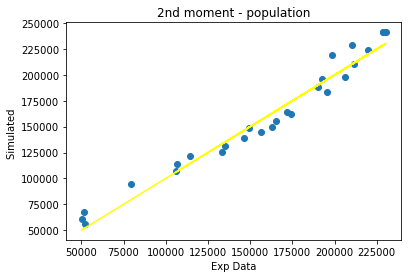

In [24]:
## plotting x against y 
plt.scatter( MuS_consDict['array'][:nConds]  ,Mu_Pop )
plt.plot(MuS_consDict['array'][:nConds], MuS_consDict['array'][:nConds], c = 'yellow')
plt.title(r'$\mu$  - Population')
plt.xlabel('Exp Data')
plt.ylabel('Simulated ')
plt.show()

plt.scatter(MuS_consDict['array'][nConds:], S_Pop)
plt.plot(MuS_consDict['array'][nConds:], MuS_consDict['array'][nConds:], c = 'yellow')
plt.xlabel('Exp Data')
plt.ylabel('Simulated ')
plt.title(r'2nd moment - population')




plt.show()

In [25]:
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)

std_sim = np.sqrt(S_Pop - Mu_Pop**2)
mu_exp = MuS_consDict['array'][:nConds]
s_exp = MuS_consDict['array'][nConds:]

std_exp = np.sqrt(s_exp - mu_exp**2)

Text(0.5, 1.0, 'std - population')

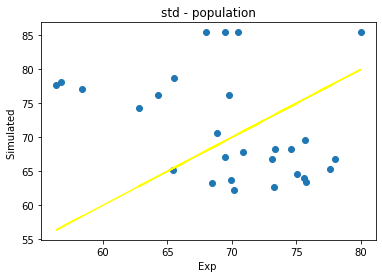

In [26]:
plt.scatter(std_exp, std_sim)
plt.plot(std_exp, std_exp, c = 'yellow')
plt.xlabel('Exp ')
plt.ylabel('Simulated ')
plt.title(r'std - population')

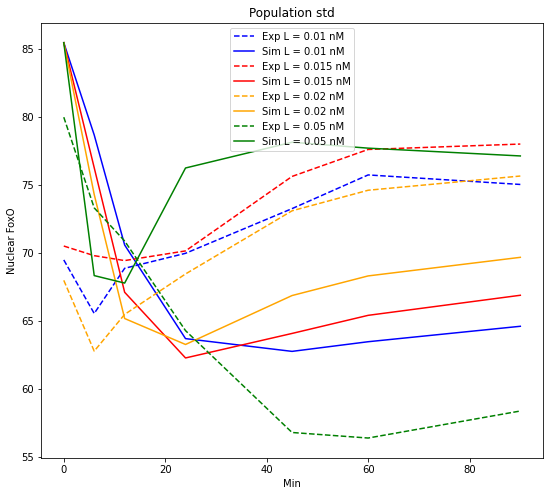

In [27]:
fig, axis = plt.subplots(figsize = (9,8))
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)
f = nConds
c = ['b','r','orange','g','k','purple']
i=0
for li in range(nL):
    plt.plot(times_arr/60, std_exp[i:i+nT], '--', label = f'Exp L = {L[li]} nM', c=c[li])
    plt.plot(times_arr/60, std_sim[i:i+nT],  label = f'Sim L = {L[li]} nM', c=c[li])
    
    i+=nT

plt.title('Population std')
plt.xlabel('Min')
plt.ylabel('Nuclear FoxO')
plt.legend()

In [17]:
std_sim.shape

(28,)

### Compare the cumulative distribution between both 

In [18]:
from collections import defaultdict
from scipy.stats import gamma 



In [19]:

boundsdict = np.load(spec_folder+'Arrays_for_max_ent/pcon_dict_250222.npy', allow_pickle=True).item()
boundsdict['0.1']


array([386.75755122, 372.40782751, 369.21130508, 349.60543963,
       320.25776825, 306.24699081, 303.76340978, 385.5237622 ,
       376.47811512, 362.45957134, 321.69236245, 281.657033  ,
       264.38394875, 261.39181366, 388.57121543, 362.56985019,
       349.8281672 , 295.38311468, 240.55654211, 226.80302712,
       224.08278862, 374.14766873, 341.56687039, 301.73790835,
       195.49232158, 150.61726016, 148.53657874, 150.41805383])

In [20]:
DataDict = np.load(spec_folder+'ProDataDict.npy', allow_pickle=True)
DataDict = DataDict.item()
time_values = [0,6,12,24,45,60,90] #minutes 
times_constrained = np.array(time_values) #minutes 

idx_list = np.array(times_constrained/3, dtype=int)
dist_gparams = defaultdict(lambda:'not present')
perc_arr = np.arange(.1,1,.1)
print(perc_arr)
pcl_dict = defaultdict(lambda:'not present') #percentile constraint dictionary
# pcl = [] #percentile constraint list 
for key in DataDict:
    # relevant data
    drel  = DataDict[key][idx_list,:]
    
    muarr = np.mean(drel, axis = 1)
    vararr = np.var(drel, axis = 1)
    
    alpha_arr = (muarr**2)/(vararr)
    scale_arr = vararr/muarr
    
    
    # dist_gparams[key] =  {'alphas' : alpha_arr, 'scales': scale_arr}
    
    for p in perc_arr: 
        pcl_dict[f'{key}_{np.round(p,2)}'] = gamma.ppf(p,alpha_arr , scale = scale_arr)
        
pcl_dict = dict(pcl_dict)  

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


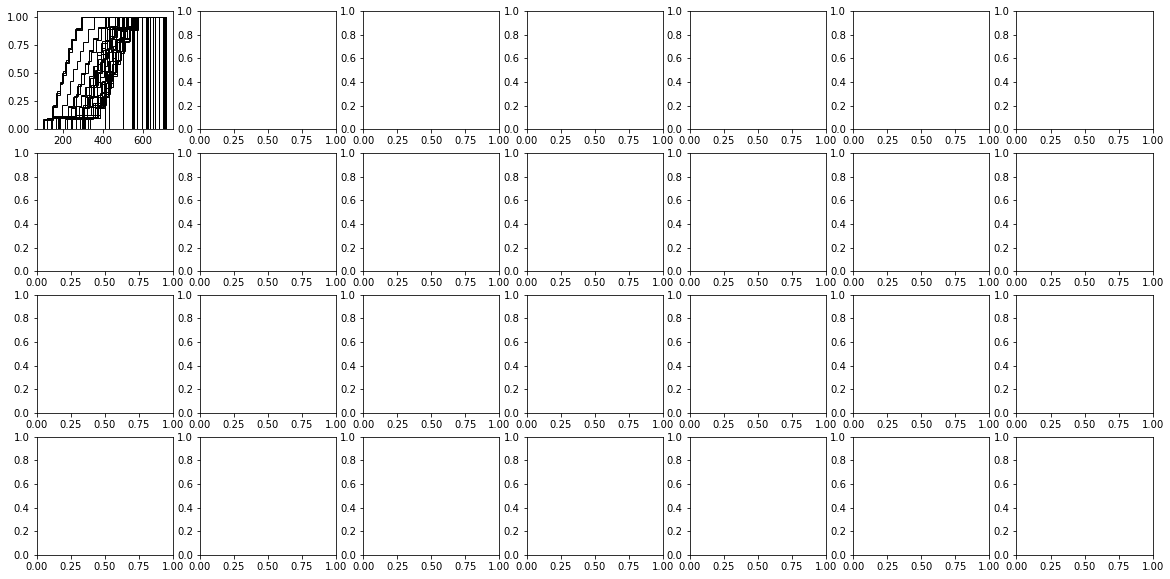

In [21]:
#  Check the error of those constraints ! 
# for each condition, draw the histogram defined by those boundaries 
time_values = [0,6,12,24,45,60,90] #minutes 
times_constrained = np.array(time_values) #minutes 

idx_list = np.array(times_constrained/3, dtype=int)
# dist_gparams = defaultdict(lambda:'not present')
perc_arr = np.arange(.1,1,.1)
print(perc_arr)
nT = len(time_values)


# pcl_dict = defaultdict(lambda:'not present') #percentile constraint dictionary
# pcl = [] #percentile constraint list
nR = len(DataDict)
fig, axs = plt.subplots(nR,nT, figsize = (20,10))
nr = 0; nc = 0;
exp_bins_dict = defaultdict(lambda:'not present')
for key in DataDict:
    # relevant data
    for ii in range(nT):
        # print(f'{key}_{times_constrained[ii]}min')
        drel  = DataDict[key][idx_list[ii],:]
        bins = np.zeros((len(perc_arr)+2))
        bins[0]=np.min(drel)
        bins[-1] = np.max(drel)
        for j in range(0,len(perc_arr)): 
            k = f'{key}_{np.round(perc_arr[j],2)}'
            # print(k)
            bins[j+1] = pcl_dict[k][ii]
        # print('bins:', bins)
        n, bins, patches = axs[nr, nc].hist(drel,edgecolor='black', bins=bins, cumulative = True, density=True, histtype='step')
        key2= f'{key}_{time_values[ii]}Min'
        exp_bins_dict[key2] = n
        
        
#         axs[nr, nc].set_title(f'{key}_{times_constrained[ii]}min')
#         axs[nr, nc].set_xlabel('nuclear FoxO')
#         axs[nr, nc].set_ylabel('count')
#         # plt.show()
#         nc+=1 
#         if nc==nT: 
#             nc=0
#             nr+=1 
# plt.tight_layout()

In [22]:
## percentiles 
cellpreds_np = read_csv(path = path, index = latest_iteration)#, dat = 'cell_preds')



In [23]:
cellpreds_np.shape

(19996, 252)

In [24]:
# cellpreds_np = read_csv(path = path, index = Best_iteration)

In [25]:
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)
perc_arr = np.arange(.1,1,.1)
print(perc_arr)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [26]:
cpmean = np.mean(cellpreds_np, axis =0)
cpmean.shape

(252,)

In [27]:
nppc = 9 

Per_Mat = np.empty((nppc,nConds ))
k=0
for i in range(nppc):
    Per_Mat[i,:] = cpmean[k:k+nConds]
    k+=nConds
    
# for i in nConds: 
#     for pi in range(len(perc_arr)):
# Per_Mat    

In [28]:
cum_mat = np.empty_like(Per_Mat)


for i in range(nppc-1):
    cum_mat[i,:] = np.sum(Per_Mat[0:i+1,:], axis = 0)
    
cum_mat[-1,:]  = np.sum(Per_Mat, axis = 0)

In [29]:
Bound_dict_cond = defaultdict(lambda: 'not present')

for conc_key in DataDict:
    for ii in range(nT):
        cond_key= f'{conc_key}_{time_values[ii]}Min'
        Bound_dict_cond[cond_key] = np.array([]) 
        
        for pi in perc_arr:
            pi = np.round(pi, 2)
            pk = f'{conc_key}_{pi}'
            
#             print(pk)
#         # key1= f'{key}_'
#             print(pcl_dict[pk][ii])
#             print(np.array(pcl_dict[pk][ii]))
            Bound_dict_cond[cond_key] = np.concatenate((Bound_dict_cond[cond_key], np.array([pcl_dict[pk][ii]])) , axis =0 )

# pcl_dict
Bound_dict_cond = dict(Bound_dict_cond)

In [30]:
Bound_dict_cond['10pM_0Min'].shape

(9,)

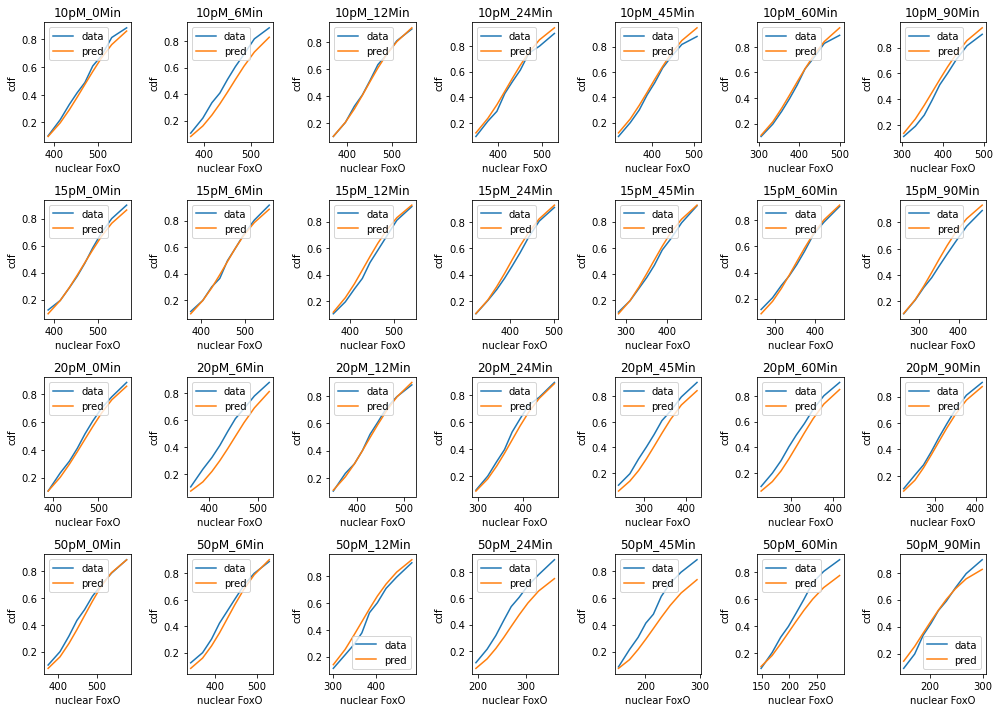

In [31]:
nR = len(DataDict)
fig, axs = plt.subplots(nR,nT, figsize = (14,10))
# nT = len(time_values)
nr = 0; nc = 0;
i=0
for key in DataDict:
    for ii in range(nT):
        key2= f'{key}_{time_values[ii]}Min'


        axs[nr,nc].plot(Bound_dict_cond[key2],exp_bins_dict[key2][:-1], label = 'data')

        axs[nr,nc].plot(Bound_dict_cond[key2], cum_mat[:,i], label = 'pred')
        
        
        axs[nr, nc].set_title(f'{key2}')
        axs[nr, nc].set_xlabel('nuclear FoxO')
        axs[nr, nc].set_ylabel('cdf')
        
        # if (nr==0 and nc==0):
            
        axs[nr, nc].legend()
    
    
        i+=1 
        nc+=1 
        
        if nc==nT:
            nc=0
            nr+=1

plt.tight_layout()
plt.show()

In [32]:
exp_bins_dict[key]

'not present'

### Get the means vs time 

In [33]:
mu_mat.shape
time_values

[0, 6, 12, 24, 45, 60, 90]

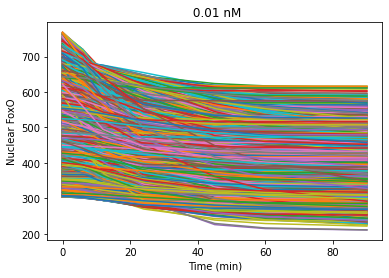

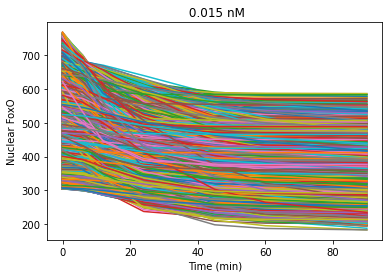

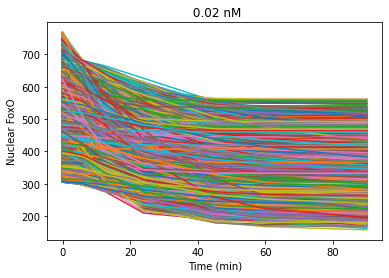

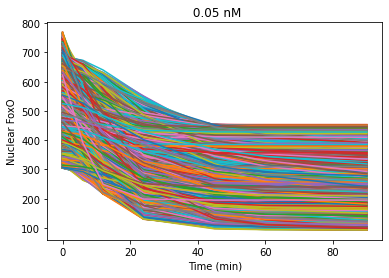

In [34]:
# fig, axs = plt.subplot()
nConc = 4
nT = len(time_values)
L  = np.array([10,15,20,50])*10**-3 #make it in nM
ncells, nconds = mu_mat.shape
for i in range(nConc):
    int_1, int_2 = nT*i , nT*i + nT
    for j in range(ncells):
        y = mu_mat[j,int_1:int_2]
        plt.plot(time_values, y )
        
    plt.title(f' {L[i] } nM')
    plt.xlabel('Time (min)')
    plt.ylabel('Nuclear FoxO')
    plt.show()